In [1]:
import pandas as pd
import numpy as np
from scipy.stats import skew
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.impute import KNNImputer

warnings.filterwarnings("ignore") 
plt.style.use('seaborn-whitegrid') ###personal setting for the graphs


# Plan

1. Identify the number and type of features 
    
2. Find the number/percentage of missing data for each feature 
    * visualize the results with a bar chart Identify the number and type of features 

3. Data distribution patterns
    * test the features and target variable for normalty 
    * plot them on histograms to visualize if they are normally distributed 
    * test transformations to achieve normal data 
    * visualize the results
    
4. Data correlations 
    * examine the correlation of each feature with the target variable 
    * examine the multicolinearity between features 
        * can also use pairplots 
    * suggests solutions to the challenges that are observed
    
5. Visualize dimension reductions 
    * segment the target Variable 
    * conduct PCA and visualize the results 
    * conduction TSNE analysis 

# Data Summary

1. Load the Data 
2. Identify initial dimensions 
3. Find missing variables for each feature and graph them - bar/scatter plot
5. find missing feature for each example and graph them - scartter plot

In [2]:
# loading the data 

raw_df = pd.read_csv("train.csv")

print(f"The number of repeated data points are: {raw_df.shape[0] - len(set(raw_df.Id))}") # setting the Ids to ensure single counts only
raw_df.drop('Id', axis=1, inplace = True)
print(f"The number of features is: {raw_df.shape[1]}")
print(f"The number of instances is: {raw_df.shape[0]}")
print("\n\n")

print("The first 5 rows of the raw dataset:")
print("\n")
raw_df.head()

The number of repeated data points are: 0
The number of features is: 80
The number of instances is: 1460



The first 5 rows of the raw dataset:




,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


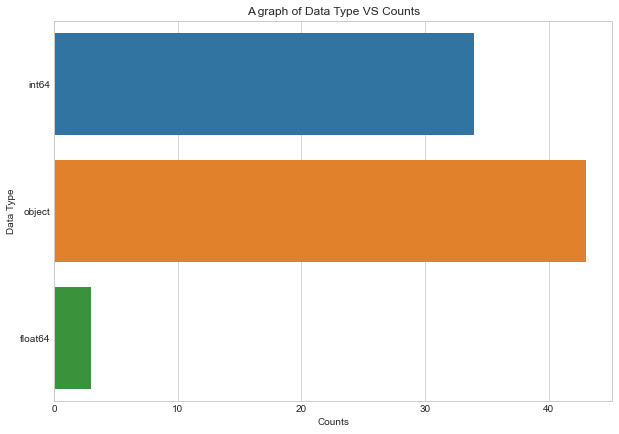

In [3]:
# inspecting the data types assigned when we uploaded the csv 

# visualizing the distribution of dtypes 
def visualize_dtypes(df):
    dtypes_list = []

    # calculating the counts of each feature
    for feature in df.columns:
        feature_dtype = df[feature].dtype.name
        dtypes_list.append(feature_dtype)

    fig,axes = plt.subplots(figsize=(10,7))
    axes = sns.countplot(y=dtypes_list)
    plt.xlabel('Counts')
    plt.ylabel('Data Type')
    plt.title('A graph of Data Type VS Counts')
    plt.show()
    
    return None

visualize_dtypes(raw_df)

In [4]:
# further inspection of data types assigned 
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   Alley          91 non-null     object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  YearBuil

The assigned data types are not representative of the true type for some of the features. Reading metadata that contains description of what each feature contains helped me identify the actual data types I would like to use. All features that contain continous variables will be converted to 'numeric' type and the rest will be converted to the 'category' type.

Certain features like 'GarageCars' and 'FullBath' were initially assigned the int type but were placed in the categorical data section because they were assessed and found to be ordinal variables.

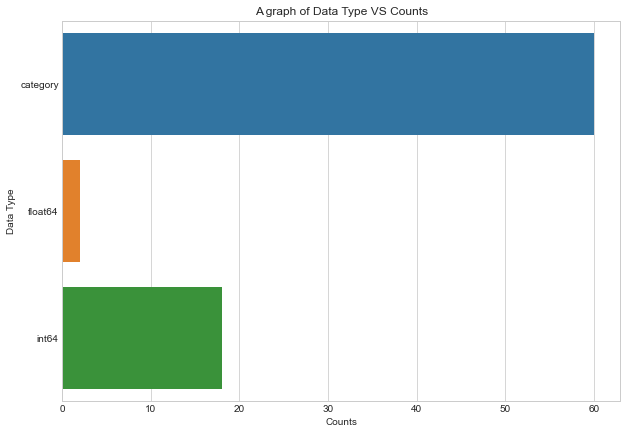

In [5]:
# Changing some default data types

feature_dtypes = {'MSSubClass':'category', 'MSZoning':'category', 'LotFrontage':'numeric', 'LotArea':'numeric', 'Street':'category',
       'Alley':'category', 'LotShape':'category', 'LandContour':'category', 'Utilities':'category', 'LotConfig':'category',
       'LandSlope':'category', 'Neighborhood':'category', 'Condition1':'category', 'Condition2':'category', 'BldgType':'category',
       'HouseStyle':'category', 'OverallQual':'category', 'OverallCond':'category', 'YearBuilt':'category', 'YearRemodAdd':'category',
       'RoofStyle':'category', 'RoofMatl':'category', 'Exterior1st':'category', 'Exterior2nd':'category', 'MasVnrType':'category',
       'MasVnrArea':'numeric', 'ExterQual':'category', 'ExterCond':'category', 'Foundation':'category', 'BsmtQual':'category',
       'BsmtCond':'category', 'BsmtExposure':'category', 'BsmtFinType1':'category', 'BsmtFinSF1':'numeric',
       'BsmtFinType2':'category', 'BsmtFinSF2':'numeric', 'BsmtUnfSF':'numeric', 'TotalBsmtSF':'numeric', 'Heating':'category',
       'HeatingQC':'category', 'CentralAir':'category', 'Electrical':'category', '1stFlrSF':'numeric', '2ndFlrSF':'numeric',
       'LowQualFinSF':'numeric', 'GrLivArea':'numeric', 'BsmtFullBath':'category', 'BsmtHalfBath':'category', 'FullBath':'category',
       'HalfBath':'category', 'BedroomAbvGr':'category', 'KitchenAbvGr':'category', 'KitchenQual':'category',
       'TotRmsAbvGrd':'category', 'Functional':'category', 'Fireplaces':'category', 'FireplaceQu':'category', 'GarageType':'category',
       'GarageYrBlt':'category', 'GarageFinish':'category', 'GarageCars':'category', 'GarageArea':'numeric', 'GarageQual':'category',
       'GarageCond':'category', 'PavedDrive':'category', 'WoodDeckSF':'numeric', 'OpenPorchSF':'numeric',
       'EnclosedPorch':'numeric', '3SsnPorch':'numeric', 'ScreenPorch':'numeric', 'PoolArea':'numeric', 'PoolQC':'category',
       'Fence':'category', 'MiscFeature':'category', 'MiscVal':'numeric', 'MoSold':'category', 'YrSold':'category', 'SaleType':'category',
       'SaleCondition':'category', 'SalePrice':'numeric'}


for feature, feature_dtype in feature_dtypes.items():
    if feature_dtype == "category":
        raw_df[f'{feature}'] = raw_df[f'{feature}'].astype(f'{feature_dtype}')
    else:
        raw_df[f'{feature}'] = pd.to_numeric(raw_df[f'{feature}'])

# visualise the new dtypes
visualize_dtypes(raw_df)

It appears that over 2/3 of our features are categorical. Several features denote the year some feature or house was built or sold. They were temporarily marked as categorical variables because they resemble ordinal data more than continous data. They will later be transformed into 'age' but subtracting them from the year the house was sold. 'Age' will be a continous varible. 

## Missing Data

Missing data is a problem that may affect the ultimate number of examples we have for modeling. The percentage of missing data influences how we will handle such data. If only a few examples are missing within a feature, then we may look at replacing them with the mean or most frequent value for that feature. 

If an example has too many missing values across to many feature, we may want to delete it all together. This approach can be take for features that has to many values missing as well. For our puposes, features missing more than 10% of the data will be removed as well as examples missing more than 10% of their data.  

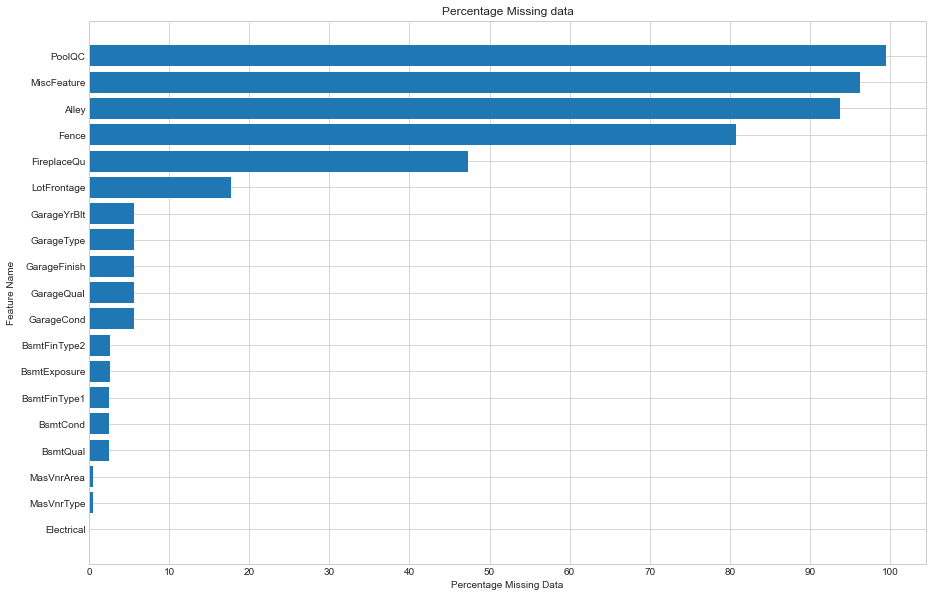

In [6]:
# missing values as a percentage of the data 

missing_data = (raw_df.isnull().sum()/raw_df.shape[0]) * 100
missing_data = missing_data[missing_data > 0]
missing_data.sort_values(ascending=True,inplace=True)

fig,axes = plt.subplots(figsize=(15,10))
axes = plt.barh(missing_data.index, width =np.array(missing_data) )
plt.xlabel('Percentage Missing Data')
plt.ylabel('Feature Name')
plt.xticks([x for x in range(0,110,10)])
plt.title('Percentage Missing data')
plt.show()

The above graph shows that 6 features have more than 10% missing data. They will be eliminated from the data set before further explorations can be done. Another  12 features are missing about 5% or less of their data. It seems reasonable to impute values for the latter features and disregard the former. There is no missing data in the target variable. 

In [7]:
# removing columns with too many missing values 

raw_df.drop(missing_data[missing_data > 10].index, axis = 1, inplace = True)
print(f"The number of features is now: {raw_df.shape[1]}")
print(f"The number of instances is now : {raw_df.shape[0]}")
print("\n\n")

The number of features is now: 74
The number of instances is now : 1460





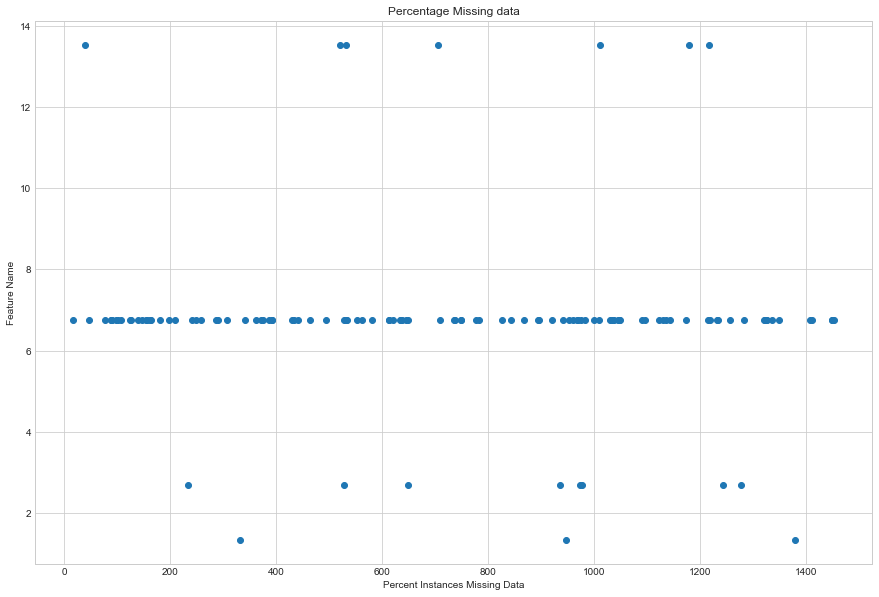

In [8]:
# checking instances with missing values 

instances_missing_data = (raw_df.isnull().sum(axis=1)/raw_df.shape[1]) * 100
instances_missing_data = instances_missing_data[instances_missing_data > 0]
instances_missing_data.sort_values(ascending=True,inplace=True)

fig,axes = plt.subplots(figsize=(15,10))
axes = plt.scatter(x=instances_missing_data.index, y =np.array(instances_missing_data) )
plt.xlabel('Percent Instances Missing Data')
plt.ylabel('Feature Name')
plt.title('Percentage Missing data')
plt.show()

There are 7 instances missing over 10% of their data. Another 115 are missing less than 7% data. Those missing above 10 percent data will be disregards and the rest will be imputted. 

In [9]:
# removing columns with too many missing values 
raw_df.drop(instances_missing_data[instances_missing_data > 10].index, axis = 0, inplace = True)

print(f"The number of features is now: {raw_df.shape[1]}")
print(f"The number of instances is now : {raw_df.shape[0]}")
print("\n\n")

The number of features is now: 74
The number of instances is now : 1453





### Imputing missing data 

For imputing purposes, the data will be separated between catergorical and numeric. This allows us to use the KNN imputer for numeric variables and use the most frequent value to impute missing values in the categorical features. 

In [17]:
# separating data by type

catergorical_df = raw_df[raw_df.select_dtypes(include = ["category"]).columns]
numeric_df = raw_df[raw_df.select_dtypes(include = ["float64", "int64"]).columns]

In [27]:
# find the number of missing data in the numeric df before imputations 
print(f"The numner of missing numeric values is: {numeric_df.isnull().values.sum()}")

The numner of missing numeric values is: 8


In [32]:
# imputing missing numeric data 

# define imputer
imputer = KNNImputer(n_neighbors=5, weights='uniform', metric='nan_euclidean') # nan_euclidean ignores missing values

# fit on the dataset
imputer.fit(numeric_df)

# fit on the dataset
imputer.fit(numeric_df)

# transform the dataset
numeric_df = imputer.transform(numeric_df)

#check for missing data 
print('The numner of missing numeric values is now:{}\n'.format(sum(np.isnan(numeric_df).flatten())))



The numner of missing numeric values is now:0



In [33]:
# imputing missing categorical data 